In [16]:
import os 
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from tqdm import tqdm
from PIL import Image

In [2]:
os.listdir("./dataset/")

['trainB', 'trainA', 'testB', 'testA']

### Посмотрим на распределение


In [3]:
len(os.listdir("./dataset/trainA/"))

400

In [4]:
len(os.listdir("./dataset/testA/"))

106

### Есть 400 train изображений и 106 test

In [36]:
# custom dataset
class MyDataset(Dataset):
    def __init__(self, x_paths, y_paths, transforms=None):
        self.x_paths = x_paths
        self.y_paths = y_paths
        self.low_thresh = np.array([0,120,250])
        self.high_thresh = np.array([15, 128, 255])
        if transforms:
            self.transforms = transforms
    
    def __len__(self):
        return len(self.x_paths)
    
    def __getitem__(self, idx):
        x = Image.open(self.x_paths[idx])
        y = self.prepare_y(self.y_paths[idx])
        if self.transforms:
            x = self.transforms(x)
        return x, y
    
    def prepare_y(self, path):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img1 = cv2.inRange(img, np.array([0,100,250]), np.array([20, 130, 255]))
        img2 = cv2.inRange(img, np.array([230,230,0]), np.array([255, 255, 20]))


        contours, _ = cv2.findContours(img1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours2, _ = cv2.findContours(img2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for cont in contours:
            con = cv2.minAreaRect(cont)
            con = np.intp(cv2.boxPoints(con))
            cv2.drawContours(img1, [con], 0, (255,255,255), -1)
        for cont in contours2:
            con = cv2.minAreaRect(cont)
            con = np.intp(cv2.boxPoints(con))
            cv2.drawContours(img1, [con], 0, (255,255,255), -1)
        return torch.tensor(img1 / 255)
    
#     def prepare_y(self, path):
#         img = cv2.imread(path)
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#         img = cv2.inRange(img, np.array([0,100,250]), np.array([20, 130, 255]))
#         contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#         for cont in contours:
#             con = cv2.minAreaRect(cont)
#             con = np.intp(cv2.boxPoints(con))
#             cv2.drawContours(img, [con], 0, (255,255,255), -1)
#         return T.ToTensor()(img)

In [37]:
# Расчет mean и std
def mean_std(path):
    dataset = []
    mean = np.array([0.,0.,0.])
    std = np.array([0.,0.,0.])
    for imgpath in os.listdir(path):
        img = cv2.imread(f"{path}{imgpath}")
        cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(float) / 255.
        mean += img.mean(axis=(0,1))
        std += img.std(axis=(0,1))
    mean = mean / len(os.listdir(path))
    std = std / len(os.listdir(path))
    return mean, std
    
mean, std = mean_std("./dataset/trainA/")
transforms = T.Compose([
    T.Resize((256, 256)),
    T.ColorJitter(0.2,0.2,0.2),
    T.ToTensor(),
    T.Normalize(std=std, mean=mean)
])   
val_transforms = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
    T.Normalize(std=std, mean=mean)
])   

val_size = 0.2
paths = os.listdir("./dataset/trainA/")
x_paths = np.array([f"./dataset/trainA/{path}" for path in paths])
y_paths = np.array([f"./dataset/trainB/{path.replace('A', 'B')}" for path in paths])
X_train = x_paths[:int(len(x_paths) * (1 - val_size))]
y_train = y_paths[:int(len(y_paths) * (1 - val_size))]
X_val = x_paths[int(len(x_paths) * (1 - val_size)):]
y_val = y_paths[int(len(y_paths) * (1 - val_size)):]
# print(X_train[:5], y_train[:5])
# print(X_val[:5], y_val[:5])
train_set = MyDataset(X_train, y_train, transforms)
val_set = MyDataset(X_val, y_val, val_transforms)
train_loader = DataLoader(train_set, batch_size=2, shuffle=True)
val_loader = DataLoader(val_set, batch_size=1, shuffle=False)

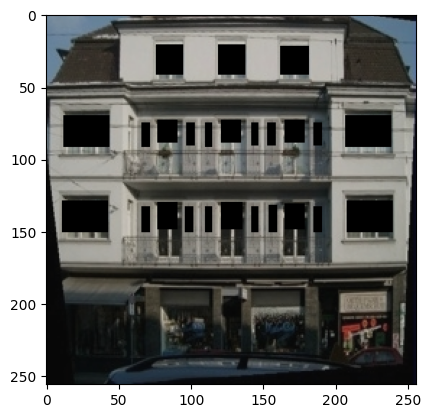

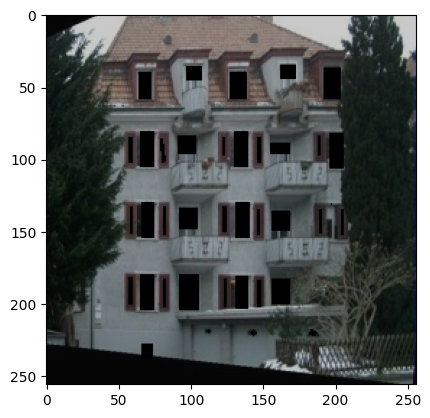

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([256, 256])


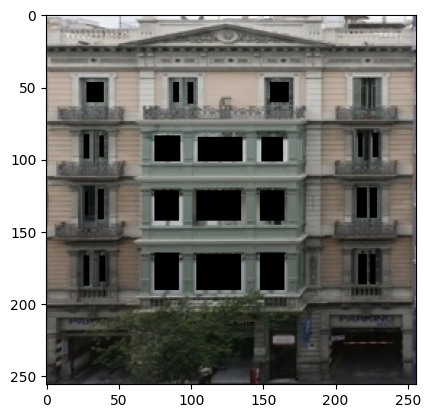

In [38]:
# Посмотрим датасет
X, y = next(iter(train_loader))
for i in range(len(X)):
    img, mask = X[i], y[i]
    img = img.numpy().transpose(1,2,0) * std + mean
    mask = (mask == 0)
    ov = cv2.bitwise_and(img, img, mask=np.array(mask).astype("uint8"))
    plt.imshow(ov)
    plt.show()
X, y = next(iter(val_loader))
for i in range(len(X)):
    img, mask = X[i], y[i]
    img = img.numpy().transpose(1,2,0) * std + mean
    print(mask.shape)
    mask = (mask == 0)
    ov = cv2.bitwise_and(img, img, mask=np.array(mask).astype("uint8"))
    plt.imshow(ov)
    plt.show()

# Эксперименты

In [39]:
class MyFCNNet(nn.Module):
    def __init__(self, in_chanels, activation):
        super().__init__()
        self.layer1 = Sequential(
            nn.Conv2d(in_chanels, 64, 3, padding=1),
            activation,
            nn.Conv2d(64, 64, 3, padding=1),
            activation,
            nn.MaxPool2d(kernel_size=2, stride=2) # 128
        )
        self.layer2 = Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            activation,
            nn.Conv2d(128, 128, 3, padding=1),
            activation,
            nn.Conv2d(128, 128, 3, padding=1),
            activation,
            nn.MaxPool2d(kernel_size=2, stride=2) # 64
        )
        self.layer3 = Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            activation,
            nn.Conv2d(256, 256, 3, padding=1),
            activation,
            nn.Conv2d(256, 256, 3, padding=1),
            activation,
            nn.Conv2d(256, 256, 3, padding=1),
            activation,
            nn.MaxPool2d(kernel_size=2, stride=2) # 32
        )
        self.layer4 = Sequential(
            nn.Conv2d(256, 512, 3, padding=1),
            activation,
            nn.Conv2d(512, 512, 3, padding=1),
            activation,
            nn.Conv2d(512, 512, 3, padding=1),
            activation,
            nn.Conv2d(512, 512, 3, padding=1),
            activation,
            nn.MaxPool2d(kernel_size=2, stride=2) # 16
        )
        self.layer5 = Sequential(
            nn.Conv2d(512, 512, 3, padding=1),
            activation,
            nn.Conv2d(512, 512, 3, padding=1),
            activation,
            nn.Conv2d(512, 512, 3, padding=1),
            activation,
            nn.Conv2d(512, 512, 3, padding=1),
            activation,
            nn.MaxPool2d(kernel_size=2, stride=2) # 8
        )
        self.conv = nn.Conv2d(512, 1, 1) #  512 x 512 x 1
        self.up = nn.UpsamplingBilinear2d(scale_factor=32)
        self.sig = nn.Sigmoid()
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.conv(x)
        x = self.up(x)
        x = self.sig(x)
        return (x)
        

In [40]:
model = MyFCNNet(3, nn.LeakyReLU(inplace=True))
criterion = nn.BCELoss()
optim = Adam(model.parameters(), lr=0.001, amsgrad=True)

In [43]:
def train(model, criterion, optim, epochs):
    for epoch in range(epochs):
        for mode in ("train", "val"):
            if mode == "train":
                model.train()
                loader = train_loader
            else:
                model.eval()
                loader = val_loader
            
            epoch_loss = 0
            epoch_acc = 0
            for X_batch, y_batch in tqdm(loader):
                optim.zero_grad()
                preds = model(X_batch)
                loss = criterion(preds, y_batch.unsqueeze(1))
                if mode == "train":
                        loss.backward()
                        optim.step()
                epoch_loss += loss.detach().item()
                epoch_acc += (y_batch == preds.squeeze(1)) / len(loader)
            print(f"{epoch:2} | {mode} | loss: {epoch_loss} acccuracy: {epoch_acc}")

In [44]:
train(model, criterion, optim, 10)

  0%|                                                                                                                                          | 0/160 [00:04<?, ?it/s]


RuntimeError: Found dtype Double but expected Float

In [ ]:

# Определение архитектуры UNet
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv4 = nn.Conv2d(256, 512, 3, padding=1)
        self.conv5 = nn.Conv2d(512, 1024, 3, padding=1)
        self.conv6 = nn.Conv2d(1024, 512, 3, padding=1)
        self.conv7 = nn.Conv2d(512, 256, 3, padding=1)
        self.conv8 = nn.Conv2d(256, 128, 3, padding=1)
        self.conv9 = nn.Conv2d(128, 64, 3, padding=1)
        self.conv10 = nn.Conv2d(64, 1, 1)

        self.maxpool = nn.MaxPool2d(2, stride=2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x):
        x1 = nn.functional.relu(self.conv1(x))
        x2 = nn.functional.relu(self.conv2(self.maxpool(x1)))
        x3 = nn.functional.relu(self.conv3(self.maxpool(x2)))
        x4 = nn.functional.relu(self.conv4(self.maxpool(x3)))
        x5 = nn.functional.relu(self.conv5(self.maxpool(x4)))
        x = nn.functional.relu(self.conv6(self.upsample(x5)))
        x = nn.functional.relu(self.conv7(torch.cat([x, x4], dim=1)))
        x = nn.functional.relu(self.conv8(self.upsample(x)))
        x = nn.functional.relu(self.conv9(torch.cat([x, x3], dim=1)))
        x = self.conv10(self.upsample(x))
        return x

# Определение функции потерь и оптимизатора
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Обучение модели
def train(model, train_loader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 10 == 9:
                print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 10))
                running_loss = 0.0